In [122]:
import numpy as np
import matplotlib.pyplot as plt

### **<span style="background-color: yellow; color: black">2.1. Ecuaciones de Euler </span>**

Las ecuaciones de Euler gobiernan el movimiento de un flujo invíscido (no viscoso) a través de las leyes de conservación de la masa, cantidad de movimiento y energía. Consideremos un flujo 1D con velocidad $u$ en la dirección $x$. Las ecuaciones de Euler para un fluido con densidad $\rho$ y presión $p$ se escriben:


$$
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x} (\rho u) = 0 \tag{7}
$$

$$
\frac{\partial}{\partial t} (\rho u) + \frac{\partial}{\partial x} (\rho u^2 + p) = 0 \tag{8}
$$

$$
\frac{\partial}{\partial t} (\rho e_T) + \frac{\partial}{\partial x} ((\rho e_T + p)u) = 0 \tag{9}
$$

Donde la **energía total por unidad de masa** se define como:

$$
e_T = e + \frac{u^2}{2},
$$

es decir, la **energía interna** $e$ más la **energía cinética** $\frac{u^2}{2}$.
En formulación vectorial tendremos:  

$$
\frac{\partial \mathbf{u}}{\partial t} + \frac{\partial \mathbf{f}}{\partial x} = 0 \tag{10}
$$

Siendo $\mathbf{u}$ el **vector de variables conservativas**:


$$
\mathbf{u} =
\begin{bmatrix}
\rho \\
\rho u \\
\rho e_T
\end{bmatrix} \tag{11}
$$

Y $\mathbf{f}$ el **vector de flujos** correspondiente:

$$
\mathbf{f} =
\begin{bmatrix}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p)u
\end{bmatrix} \tag{12}
$$


In [123]:
def compute_euler_flux(u_vec, gamma=1.4):
    rho = u_vec[0]
    rhou = u_vec[1]
    rhoET = u_vec[2]
    
    # Derivando p de la energía total
    p = (gamma - 1) * (rhoET - 0.5 * rhou**2 / rho)
    
    # Vector de flujos
    f = np.zeros_like(u_vec)
    f[0] = rhou
    f[1] = rhou**2 / rho + p
    f[2] = (rhoET + p) * rhou / rho
    
    return f



### **<span style="background-color: yellow; color: black">2.2. El método de Richtmyer</span>**


De la misma forma que en el esquema de MacCormack, el esquema de **Richtmyer** es un método de dos pasos, dado por:

$$
u_{i+1/2}^{\,n+1/2} = \frac{1}{2} \left( u_{i+1}^{\,n} + u_i^{\,n} \right) - \frac{\Delta t}{2 \, \Delta x} \left( f_{i+1}^{\,n} - f_i^{\,n} \right)
$$

$$
u_i^{\,n+1} = u_i^{\,n} - \frac{\Delta t}{\Delta x} \left( f_{i+1/2}^{\,n+1/2} - f_{i-1/2}^{\,n+1/2} \right)
$$

Los vectores de flujo empleados en el segundo paso se obtienen al evaluar las funciones de flujo en la salida del primer paso:

$$
f_{i+1/2}^{\,n+1/2} = f \left( u_{i+1/2}^{\,n+1/2} \right)
$$

El **primer paso** es un predictor de la solución, consistente con un esquema de **Lax-Friedrichs**.  

El **segundo paso** es un corrector en el cual se aplica un esquema de **salto de rana (leap-frog)**.  

La siguiente figura ilustra la grilla de cálculo para el esquema de Richtmyer, donde el índice asociado al tiempo intermedio $n + 1/2$ requerirá de una **variable temporaria (auxiliar)** en el código.

![2.2](./images/2.2.png)

In [124]:
def richtmyer(u, nt, dt, dx, gamma=1.4):
    # CORRECCIÓN: Se invierte el orden de las dimensiones para que coincidan con 'u'
    un = np.zeros((nt, u.shape[0], u.shape[1]))
    un[0] = u.copy()
    
    for n in range(nt - 1):
        # Paso Predictor
        u_half = np.zeros((u.shape[0], u.shape[1] - 1))
        
        # Flujos en el paso de tiempo n
        f_n = np.array([compute_euler_flux(u[:, i], gamma) for i in range(u.shape[1])]).T
        
        # Ecuación del predictor (Richtmyer)
        u_half = 0.5 * (u[:, 1:] + u[:, :-1]) - (dt / (2 * dx)) * (f_n[:, 1:] - f_n[:, :-1])
        
        # Paso Corrector
        u_next = u.copy()
        
        # Flujos a partir de la solución provisional
        f_half = np.array([compute_euler_flux(u_half[:, i], gamma) for i in range(u_half.shape[1])]).T
        
        # Ecuación del corrector (Richtmyer)
        u_next[:, 1:-1] = u[:, 1:-1] - (dt / dx) * (f_half[:, 1:] - f_half[:, :-1])
        u = u_next.copy()
        un[n + 1] = u.copy()
        
    return un


### **<span style="background-color: yellow; color: black">2.3. Condiciones del ensayo</span>**

Considere un tubo de $x = -10\,\mathrm{m}$ a $x = 10\,\mathrm{m}$ con la membrana en $x = 0\,\mathrm{m}$. Las condiciones iniciales son:

$$
\mathbf{IC}_L =
\begin{pmatrix}
\rho_L \\
u_L \\
p_L
\end{pmatrix}
=
\begin{pmatrix}
1.0\,\mathrm{kg/m^3} \\
0\,\mathrm{m/s} \\
100\,\mathrm{kPa}
\end{pmatrix}
$$

$$
\mathbf{IC}_R =
\begin{pmatrix}
\rho_R \\
u_R \\
p_R
\end{pmatrix}
=
\begin{pmatrix}
0.125\,\mathrm{kg/m^3} \\
0\,\mathrm{m/s} \\
10\,\mathrm{kPa}
\end{pmatrix}
$$

La membrana se retira en $t = 0\,\mathrm{s}$. Calcule la **densidad**, **velocidad** y **presión** en $t = 0.01\,\mathrm{s}$ usando el **método de Richtmyer**.

Parámetros de simulación:


- $n_x = 81$  
- $\Delta x = 0.25$  
- $\Delta t = 0.0002$  
- $\gamma = 1.4$



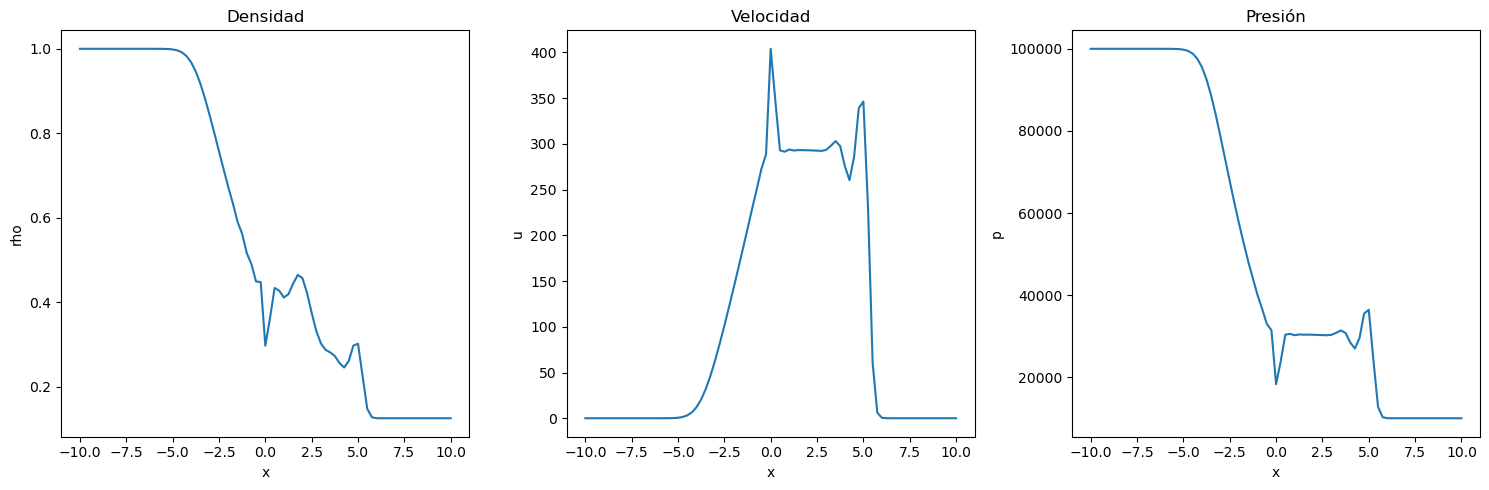

In [125]:
# --- Parámetros de la simulación del tubo de choque ---
nx = 81
dx = 0.25
dt = 0.0002
gamma = 1.4

# Dominio espacial
x = np.linspace(-10, 10, nx)

# Condición inicial
u0 = np.zeros((3, nx))
u0[0, x < 0] = 1.0  # rho_L
u0[0, x >= 0] = 0.125  # rho_R
u0[1] = 0.0  # rhou_L y rhou_R
p_L = 100e3
p_R = 10e3
u0[2, x < 0] = p_L / (gamma - 1)  # rhoET_L
u0[2, x >= 0] = p_R / (gamma - 1)  # rhoET_R

# Número de pasos de tiempo para llegar a t = 0.01 s
nt = int(0.01 / dt) + 1

# Ejecutar la simulación
solucion_euler = richtmyer(u0, nt, dt, dx, gamma)

# Obtener la solución final
u_final = solucion_euler[-1]

# Extraer y graficar variables
rho_final = u_final[0]
u_final_vel = u_final[1] / u_final[0]
p_final = (gamma - 1) * (u_final[2] - 0.5 * u_final[1]**2 / u_final[0])

# Gráficos
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x, rho_final)
plt.title('Densidad')
plt.xlabel('x')
plt.ylabel('rho')

plt.subplot(1, 3, 2)
plt.plot(x, u_final_vel)
plt.title('Velocidad')
plt.xlabel('x')
plt.ylabel('u')

plt.subplot(1, 3, 3)
plt.plot(x, p_final)
plt.title('Presión')
plt.xlabel('x')
plt.ylabel('p')
plt.tight_layout()
plt.show()